# 0. Подключение Google Colaboratory

In [1]:
# Подключение Google Drive к виртуальной машине
from google.colab import drive
drive.mount('/content/drive')

# Копирование данных с Google Drive на локальный диск виртуальной машины.
!cp -r /content/drive/MyDrive/CNN_LSTM/X_train_ptbxl_superdiag.npy .
!cp -r /content/drive/MyDrive/CNN_LSTM/X_val_ptbxl_superdiag.npy .
!cp -r /content/drive/MyDrive/CNN_LSTM/y_train_ptbxl_superdiag.npy .
!cp -r /content/drive/MyDrive/CNN_LSTM/y_val_ptbxl_superdiag.npy .

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# 1. Подключение пакетов и инициализация необходимых функций 

In [2]:
!pip install --upgrade tslearn wfdb sktime tsaug

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
# data
# system
import os
import time
import math
import ast
import random
# wfdb
import wfdb
# tqdm
from tqdm import tqdm
# numpy and pandas
import pandas as pd
import numpy as np
# sklearn
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
# tslearn
from tslearn.utils import to_time_series, to_time_series_dataset, save_time_series_txt, load_time_series_txt
from tslearn.preprocessing import TimeSeriesScalerMinMax, TimeSeriesResampler, TimeSeriesScalerMeanVariance
# sktime
from sktime.transformations.panel.compose import ColumnConcatenator
# tsaug
from tsaug import AddNoise

# visualization
# matplotlib
import matplotlib.pyplot as plt
# seaborn
import seaborn as sns
# sktime
from sktime.utils.plotting import plot_series

# metrics
# sklearn
from sklearn.metrics import confusion_matrix, f1_score, accuracy_score, pairwise_distances, classification_report
# sktime
from sktime.performance_metrics.forecasting import MeanAbsoluteScaledError, MeanSquaredError, mean_absolute_percentage_error

# model
# sklearn
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import KFold, GridSearchCV, cross_val_score
from sklearn.calibration import CalibratedClassifierCV
# sktime
from sktime.classification.interval_based import TimeSeriesForestClassifier, DrCIF
from sktime.classification.kernel_based import RocketClassifier
# tslearn
from tslearn.neighbors import KNeighborsTimeSeriesClassifier
from tslearn.svm import TimeSeriesSVC
# tensorflow
import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense, Flatten
from keras import optimizers
from keras import layers

np.random.seed(42)



In [4]:
# Transformations

def fourier_transform(X, coeffs=80):
    X_ft = np.empty_like(X)
    for i in range(len(X)):
        sample_fft = np.fft.rfft(X[i].T)
        indices = np.array([[j < coeffs for j, _ in enumerate(sample_fft[k])] for k in range(len(sample_fft))])
        X_ft[i] = np.fft.irfft(indices * sample_fft).T
    
    return X_ft

def rolling_average(X, n=4): # n - размер окна
    shape = list(X.shape)
    shape[1] -= n-1 
    X_ra = np.empty(shape)
    for i in range(len(X)):
        sample = X[i].T
        X_ra[i] = np.array([np.convolve(signal, np.ones(n), 'valid') / n for signal in sample]).T
    return X_ra

# Metrics and confusion matrix

def draw_confusion_matrix(y, y_pred):
    print(classification_report(y, y_pred))
    sns.heatmap(confusion_matrix(y, y_pred), square=True, annot=True, fmt='.0f', cmap=plt.cm.Blues)
    plt.xlabel("Predicted label")
    plt.ylabel("True label")
    pass

def draw_confusion_matrix_NN(X_test, y_test, model):
    y_pred = model.predict(X_test)
    print('score: ', model.evaluate(X_test, y_test))
    sns.heatmap(confusion_matrix(y_test, y_pred), square=True, annot=True, fmt='.0f', cmap=plt.cm.Blues)
    plt.xlabel("Predicted label")
    plt.ylabel("True label")
    pass

def elimination_imbalance(X, y):
  n_classes = y.shape[1]
  unique = np.unique(y, axis = 0)
  for i in range(n_classes):
    index_want = (np.where((y == unique[i]).all(axis=1))[0])
    num_want = math.floor(index_want.shape[0]/100)*100
    if(num_want > 2000):
      num_want = 2000
    count_of_del = index_want.shape[0] - num_want
    index_to_remove = np.random.choice(np.where((y == unique[i]).all(axis=1))[0], size=count_of_del, replace=False)
    X = np.delete(X, index_to_remove, axis=0)
    y = np.delete(y, index_to_remove, axis=0)
  return X, y

def count_of_class(X, y):
  n_classes = y.shape[1]
  unique = np.unique(y, axis = 0)
  for i in range(n_classes):
    print(np.where((y == unique[i]).all(axis=1))[0].shape[0])

def plot_ts(x):
  plt.figure(figsize=(14, 3))
  plt.plot(x[0], 'o-', linewidth=1, markeredgewidth=0.01, alpha = 0.5 ) # все 12 отведений
  plt.xlabel('time', fontsize = 14)
  plt.title('Plotting a time series', fontsize = 16)
  plt.tight_layout()
  plt.show()

# Стандартизация 3D данных c применением StandardScaler.
# Сначала изменяется форма данных а затем применяется нормализация. После этого требуется вернуть их прежнюю форму 
def standard_scaler(X_train, X_test): 
  scaler = StandardScaler()
  # Train
  num_instances, num_time_steps, num_features = X_train.shape
  X_train = np.reshape(X_train, newshape=(-1, num_features))
  X_train = scaler.fit_transform(X_train)
  X_train = np.reshape(X_train, newshape=(num_instances, num_time_steps, num_features))
  # Test
  num_instances, num_time_steps, num_features = X_test.shape
  X_test = np.reshape(X_test, newshape=(-1, num_features))
  X_test = scaler.transform(X_test)
  X_test = np.reshape(X_test, newshape=(num_instances, num_time_steps, num_features))
  return X_train, X_test

def list_sum(X):
  X_sum = []
  for i in X:
    X_sum.append(np.reshape(i, X.shape[1]*X.shape[2], order = 'A'))
  X_sum = np.array(X_sum)
  return X_sum

def del_multi_class(X, y):
  X = X[np.array([sum(x) for x in y]) == 1]
  y = y[np.array([sum(x) for x in y]) == 1]
  return X, y

# Аугментация данных
def aug(X, y):
  aug = AddNoise(scale=(0.01, 0.05))
  selected_X = X[(y == [0, 1, 0, 0, 0]).all(axis = 1)] # Выбрали конкретное значение для y в результате предварительного анализа данных. Следует обобщить 
  X_aug = np.zeros((1021, 1000, 12))
  for i in range(X_aug.shape[0]):
    X_aug[i] = aug.augment(random.choice(selected_X))
  X = np.concatenate((X, X_aug), axis=0)
  y = np.concatenate((y, np.tile([0, 1, 0, 0, 0], (1021, 1))), axis = 0)
  # Перемешаем массивы numpy
  idx = np.random.permutation(X.shape[0])
  X = X[idx]
  y = y[idx]
  print(X.shape)
  print(y.shape)
  wfdb.plot_items(signal = selected_X[0, :, 0], figsize = (14, 3))
  wfdb.plot_items(signal = X_aug[1020, :, 0], figsize = (14, 3))
  del selected_X
  del X_aug
  return X, y

# 2. Загрузка данных PTB-XL (helme)

In [5]:
X_train = np.load('X_train_ptbxl_superdiag.npy')
y_train = np.load('y_train_ptbxl_superdiag.npy')
X_test = np.load('X_val_ptbxl_superdiag.npy')
y_test = np.load('y_val_ptbxl_superdiag.npy')
print(X_train.shape, y_train.shape)

(19230, 1000, 12) (19230, 5)


# 3. Предобработка временных рядов

### Удаление многоклассовых меток

In [6]:
X_train, y_train = del_multi_class(X_train, y_train)
X_test, y_test = del_multi_class(X_test, y_test)

### Аугментация данных

(15615, 1000, 12)
(15615, 5)


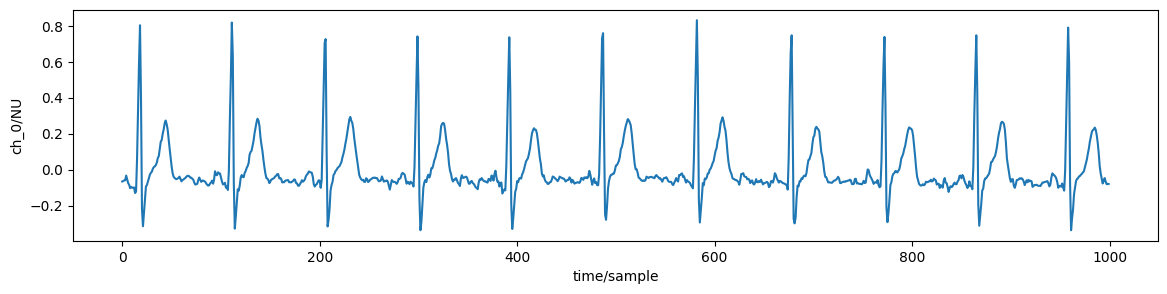

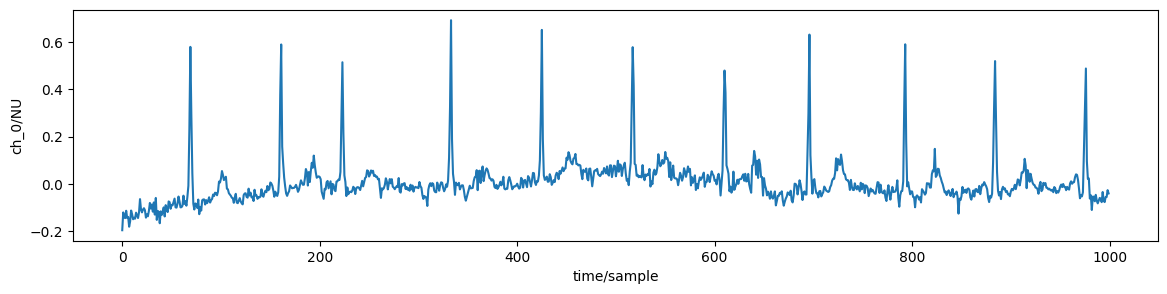

In [7]:
X_train, y_train = aug(X_train, y_train)

### Борьба с дисбалансом классов

In [8]:
X_train, y_train = elimination_imbalance(X_train, y_train)
count_of_class(X_train, y_train)
print(X_train.shape, y_train.shape)

2000
2000
2000
1500
1500
(9000, 1000, 12) (9000, 5)


### Преобразование Фурье

In [9]:
X_train_ft = fourier_transform(X_train)
X_test_ft = fourier_transform(X_test)

### Скользящее среднее

In [10]:
X_train_ra = rolling_average(X_train)
X_test_ra = rolling_average(X_test)

### Стандартизация X_train

In [11]:
X_train_ft_st, X_test_ft_st = standard_scaler(X_train_ft, X_test_ft)
X_train_ra_st, X_test_ra_st = standard_scaler(X_train_ra, X_test_ra)
X_train_st, X_test_st = standard_scaler(X_train, X_test)

In [12]:
del X_train
del X_test

### CNN_1D_LSTM

In [13]:
model = tf.keras.Sequential()
model.add(layers.GaussianNoise(stddev=0.0005, input_shape=(1000, 12)))

model.add(layers.Conv1D(64, 3, strides=1, padding='same'))
model.add(layers.BatchNormalization())
model.add(layers.ReLU())
model.add(layers.MaxPooling1D(pool_size=2))

model.add(layers.Conv1D(128, 3, strides=1, padding='same'))
model.add(layers.BatchNormalization())
model.add(layers.ReLU())
for _ in range(8):
  model.add(layers.Conv1D(256, 3, strides=1, padding='same'))
  model.add(layers.BatchNormalization())
  model.add(layers.ReLU())
  model.add(layers.MaxPooling1D(pool_size=2))

model.add(layers.Flatten())
model.add(layers.BatchNormalization())
model.add(layers.Reshape((-1, 256)))
model.add(layers.LSTM(32, return_sequences=True))
model.add(layers.BatchNormalization())
model.add(layers.LSTM(32))
model.add(layers.BatchNormalization())
model.add(layers.Dense(5, activation='softmax'))

In [14]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gaussian_noise (GaussianNoi  (None, 1000, 12)         0         
 se)                                                             
                                                                 
 conv1d (Conv1D)             (None, 1000, 64)          2368      
                                                                 
 batch_normalization (BatchN  (None, 1000, 64)         256       
 ormalization)                                                   
                                                                 
 re_lu (ReLU)                (None, 1000, 64)          0         
                                                                 
 max_pooling1d (MaxPooling1D  (None, 500, 64)          0         
 )                                                               
                                                        

In [15]:
# Реализация раннего прекращения.
checkpoint_filepath = './checkpoint_CNN_lstm/'
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_filepath,
                                                      save_weights_only=True,
                                                      save_best_only=True)
early_stopping = keras.callbacks.EarlyStopping(patience=15,
                                              restore_best_weights=True)

model.compile(loss = keras.losses.CategoricalCrossentropy(),
              optimizer=tf.optimizers.Adam(),
              metrics=['accuracy'])

history = model.fit(X_train_st, y_train, 
                      epochs = 100, 
                      validation_data = None, 
                      validation_split=0.1, 
                      callbacks=[model_checkpoint, early_stopping])

# Сохранение модели
model.save('CNN_lstm_superdiag_1')

Epoch 1/100
254/254 [==============================] - 35s 53ms/step - loss: 1.0927 - accuracy: 0.5831 - val_loss: 1.1267 - val_accuracy: 0.6189
Epoch 2/100
254/254 [==============================] - 10s 38ms/step - loss: 0.8736 - accuracy: 0.6798 - val_loss: 0.9565 - val_accuracy: 0.6444
Epoch 3/100
254/254 [==============================] - 9s 34ms/step - loss: 0.7977 - accuracy: 0.7069 - val_loss: 0.7299 - val_accuracy: 0.7289
Epoch 4/100
254/254 [==============================] - 10s 39ms/step - loss: 0.7593 - accuracy: 0.7242 - val_loss: 0.7397 - val_accuracy: 0.7467
Epoch 5/100
254/254 [==============================] - 10s 38ms/step - loss: 0.7432 - accuracy: 0.7230 - val_loss: 0.9870 - val_accuracy: 0.6633
Epoch 6/100
254/254 [==============================] - 9s 35ms/step - loss: 0.7679 - accuracy: 0.7200 - val_loss: 0.6711 - val_accuracy: 0.7489
Epoch 7/100
254/254 [==============================] - 10s 38ms/step - loss: 0.6582 - accuracy: 0.7622 - val_loss: 0.7289 - val_accu

52/52 [==============================] - 2s 16ms/step - loss: 0.8288 - accuracy: 0.7085
score:  [0.8288003206253052, 0.7084848284721375]
52/52 [==============================] - 2s 9ms/step
              precision    recall  f1-score   support

           0       0.57      0.77      0.65       184
           1       0.29      0.52      0.37        56
           2       0.68      0.63      0.65       256
           3       0.87      0.72      0.79       912
           4       0.59      0.75      0.66       242

    accuracy                           0.71      1650
   macro avg       0.60      0.68      0.63      1650
weighted avg       0.74      0.71      0.72      1650



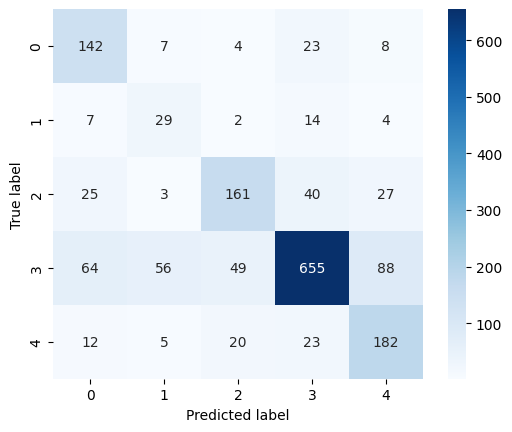

In [16]:
print('score: ', model.evaluate(X_test_st, y_test))
y_pred = model.predict(X_test_st)
draw_confusion_matrix(np.argmax(y_test, axis =1), np.argmax(y_pred, axis = 1))

In [17]:
# Реализация раннего прекращения.
checkpoint_filepath = './checkpoint_CNN_lstm/'
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_filepath,
                                                      save_weights_only=True,
                                                      save_best_only=True)
early_stopping = keras.callbacks.EarlyStopping(patience=15,
                                              restore_best_weights=True)

history = model.fit(X_train_ft_st, y_train, 
                      epochs = 100, 
                      validation_data = None, 
                      validation_split=0.1, 
                      callbacks=[model_checkpoint, early_stopping])

# Сохранение модели
model.save('CNN_lstm_superdiag_2')

Epoch 1/100
254/254 [==============================] - 10s 39ms/step - loss: 0.7231 - accuracy: 0.7284 - val_loss: 0.8862 - val_accuracy: 0.6833
Epoch 2/100
254/254 [==============================] - 9s 36ms/step - loss: 0.5382 - accuracy: 0.8049 - val_loss: 0.9070 - val_accuracy: 0.6800
Epoch 3/100
254/254 [==============================] - 9s 37ms/step - loss: 0.4463 - accuracy: 0.8402 - val_loss: 0.9540 - val_accuracy: 0.7011
Epoch 4/100
254/254 [==============================] - 10s 39ms/step - loss: 0.3620 - accuracy: 0.8679 - val_loss: 1.0434 - val_accuracy: 0.6578
Epoch 5/100
254/254 [==============================] - 9s 34ms/step - loss: 0.3109 - accuracy: 0.8883 - val_loss: 1.0749 - val_accuracy: 0.6822
Epoch 6/100
254/254 [==============================] - 10s 38ms/step - loss: 0.2545 - accuracy: 0.9104 - val_loss: 1.2101 - val_accuracy: 0.6811
Epoch 7/100
254/254 [==============================] - 10s 41ms/step - loss: 0.2193 - accuracy: 0.9232 - val_loss: 1.1269 - val_accur

52/52 [==============================] - 1s 12ms/step - loss: 0.9084 - accuracy: 0.6836
score:  [0.9083589911460876, 0.6836363673210144]
52/52 [==============================] - 1s 9ms/step
              precision    recall  f1-score   support

           0       0.46      0.53      0.49       184
           1       0.29      0.39      0.33        56
           2       0.57      0.43      0.49       256
           3       0.81      0.79      0.80       912
           4       0.62      0.73      0.67       242

    accuracy                           0.68      1650
   macro avg       0.55      0.57      0.56      1650
weighted avg       0.69      0.68      0.68      1650



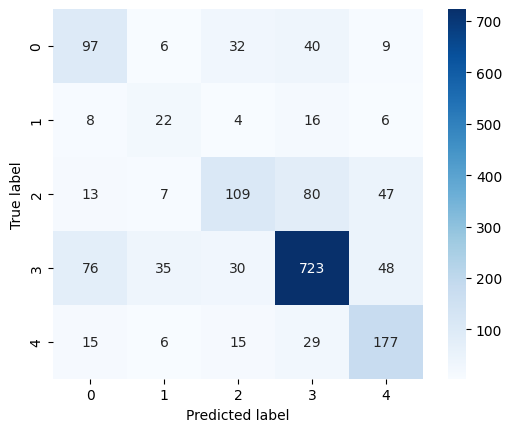

In [18]:
print('score: ', model.evaluate(X_test_ft_st, y_test))
y_pred = model.predict(X_test_ft_st)
draw_confusion_matrix(np.argmax(y_test, axis =1), np.argmax(y_pred, axis = 1))

In [20]:
model = tf.keras.Sequential()
model.add(layers.GaussianNoise(stddev=0.0005, input_shape=(997, 12)))

model.add(layers.Conv1D(64, 3, strides=1, padding='same'))
model.add(layers.BatchNormalization())
model.add(layers.ReLU())
model.add(layers.MaxPooling1D(pool_size=2))

model.add(layers.Conv1D(128, 3, strides=1, padding='same'))
model.add(layers.BatchNormalization())
model.add(layers.ReLU())
for _ in range(8):
  model.add(layers.Conv1D(256, 3, strides=1, padding='same'))
  model.add(layers.BatchNormalization())
  model.add(layers.ReLU())
  model.add(layers.MaxPooling1D(pool_size=2))

model.add(layers.Flatten())
model.add(layers.BatchNormalization())
model.add(layers.Reshape((-1, 256)))
model.add(layers.LSTM(32, return_sequences=True))
model.add(layers.BatchNormalization())
model.add(layers.LSTM(32))
model.add(layers.BatchNormalization())
model.add(layers.Dense(5, activation='softmax'))

# Реализация раннего прекращения.
checkpoint_filepath = './checkpoint_CNN_lstm/'
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_filepath,
                                                      save_weights_only=True,
                                                      save_best_only=True)
early_stopping = keras.callbacks.EarlyStopping(patience=15,
                                              restore_best_weights=True)

model.compile(loss = keras.losses.CategoricalCrossentropy(),
              optimizer=tf.optimizers.Adam(),
              metrics=['accuracy'])

history = model.fit(X_train_ra_st, y_train, 
                      epochs = 100, 
                      validation_data = None, 
                      validation_split=0.1, 
                      callbacks=[model_checkpoint, early_stopping])

# Сохранение модели
model.save('CNN_lstm_superdiag_1')

Epoch 1/100
254/254 [==============================] - 32s 47ms/step - loss: 1.1297 - accuracy: 0.5699 - val_loss: 1.1806 - val_accuracy: 0.5933
Epoch 2/100
254/254 [==============================] - 9s 35ms/step - loss: 0.9080 - accuracy: 0.6744 - val_loss: 0.8937 - val_accuracy: 0.6867
Epoch 3/100
254/254 [==============================] - 10s 39ms/step - loss: 0.8416 - accuracy: 0.6911 - val_loss: 0.9690 - val_accuracy: 0.6567
Epoch 4/100
254/254 [==============================] - 10s 39ms/step - loss: 0.7970 - accuracy: 0.7127 - val_loss: 0.9370 - val_accuracy: 0.6889
Epoch 5/100
254/254 [==============================] - 9s 34ms/step - loss: 0.7218 - accuracy: 0.7360 - val_loss: 0.9299 - val_accuracy: 0.6689
Epoch 6/100
254/254 [==============================] - 11s 45ms/step - loss: 0.6994 - accuracy: 0.7500 - val_loss: 0.7181 - val_accuracy: 0.7444
Epoch 7/100
254/254 [==============================] - 10s 38ms/step - loss: 0.6601 - accuracy: 0.7641 - val_loss: 0.8495 - val_accu

52/52 [==============================] - 2s 14ms/step - loss: 0.8993 - accuracy: 0.6909
score:  [0.8992729187011719, 0.6909090876579285]
52/52 [==============================] - 1s 8ms/step
              precision    recall  f1-score   support

           0       0.73      0.70      0.71       184
           1       0.31      0.29      0.30        56
           2       0.65      0.57      0.61       256
           3       0.89      0.70      0.78       912
           4       0.44      0.88      0.59       242

    accuracy                           0.69      1650
   macro avg       0.61      0.63      0.60      1650
weighted avg       0.75      0.69      0.70      1650



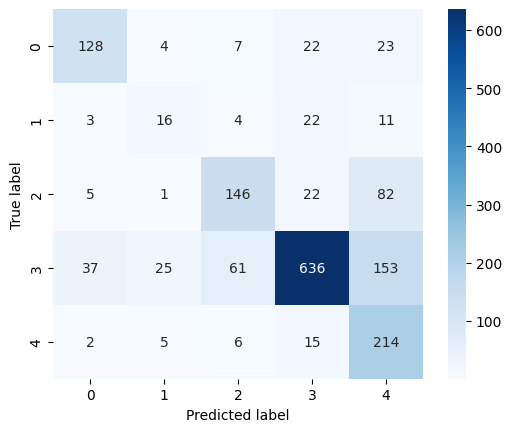

In [21]:
print('score: ', model.evaluate(X_test_ra_st, y_test))
y_pred = model.predict(X_test_ra_st)
draw_confusion_matrix(np.argmax(y_test, axis =1), np.argmax(y_pred, axis = 1))